<a href="https://colab.research.google.com/github/tul17ii/Auto-Tagging-for-Beats/blob/main/Auto_Tagging_for_Beats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install numpy pandas librosa soundfile scikit-learn torch torchvision torchaudio tqdm


In [ ]:
# Download & extract OpenMIC-2018 (official Zenodo)
!wget -q --show-progress -O /content/openmic-2018-v1.0.0.tgz \
  "https://zenodo.org/records/1432913/files/openmic-2018-v1.0.0.tgz?download=1"

!mkdir -p /content && tar -xzf /content/openmic-2018-v1.0.0.tgz -C /content
!ls -lah /content/openmic-2018 | head -n 20


/content/openmic-20 100%[===================>]   2.44G  3.16MB/s    in 7m 2s   
total 233M
drwxr-xr-x   6  501 staff 4.0K Sep 22  2018 .
drwxr-xr-x   1 root root  4.0K Sep 17 17:27 ..
-rw-r--r--   1  501 staff  976 Sep 19  2018 acknowledgement.md
drwxr-xr-x 158  501 staff 4.0K Sep 17 17:28 audio
drwxr-xr-x   2  501 staff 4.0K Sep 17 17:28 checksums
-rw-r--r--   1  501 staff 1.2K Sep 20  2018 ._class-map.json
-rw-r--r--   1  501 staff  292 Sep 20  2018 class-map.json
-rw-r--r--   1  501 staff  186 Sep 18  2018 ._license-cc-by.txt
-rw-r--r--   1  501 staff  19K Sep 18  2018 license-cc-by.txt
-rw-r--r--   1  501 staff 1.2M Sep 20  2018 openmic-2018-aggregated-labels.csv
-rw-r--r--   1  501 staff  11M Sep 20  2018 openmic-2018-individual-responses.csv
-rw-r--r--   1  501 staff  239 Jul 19  2018 ._openmic-2018-metadata.csv
-rw-r--r--   1  501 staff  23M Jul 19  2018 openmic-2018-metadata.csv
-rw-r--r--   1  501 staff 200M Sep 22  2018 openmic-2018.npz
drwxr-xr-x   2  501 staff 4.0K Sep 17 1

In [ ]:
import os, shutil, pandas as pd
ROOT = "/content/openmic-2018"
agg_csv = os.path.join(ROOT, "openmic-2018-aggregated-labels.csv")

df = pd.read_csv(agg_csv)
print("Cols:", list(df.columns)[:10]); print("Rows:", len(df))

# --- robust way to detect positive labels across possible schemas
cols = {c.lower(): c for c in df.columns}
# expected columns
col_key  = cols.get('sample_key') or cols.get('samplekey') or 'sample_key'
col_inst = cols.get('instrument') or 'instrument'

# choose a target column / rule
pos_mask = None
for candi in ['target','is_present','present','label','y','truth', 'relevance']: # Added 'relevance' here
    c = cols.get(candi)
    if c and c in df:
        if candi == 'relevance': # Special handling for 'relevance' column
            pos_mask = (df[c].astype(float) >= 0.5)
        else:
            val = df[c].astype(str).str.lower()
            pos_mask = val.isin(['1','true','yes','y'])
        break

if pos_mask is None:
    # fallback: probability-style columns
    for candi in ['prob','probability','p']:
        c = cols.get(candi)
        if c and c in df:
            pos_mask = (df[c].astype(float) >= 0.5)
            break

if pos_mask is None:
    raise ValueError("Can't find positive-label column in aggregated CSV.")

pos = df[pos_mask][[col_key, col_inst]].copy()
pos[col_inst] = pos[col_inst].astype(str)

# pick top-10 frequent instruments
top = pos[col_inst].value_counts().head(10).index.tolist()
print("Top instruments:", top)

# keep at most 50 per instrument (you can change)
pos['rank'] = pos.groupby(col_inst).cumcount()
pos_small = pos[pos[col_inst].isin(top) & (pos['rank'] < 50)]

# consolidate tags per sample_key (multi-label)
tags_by_key = pos_small.groupby(col_key)[col_inst].apply(list).to_dict()

# prepare working dir + labels.csv
AUDIO_DIR = "/content/audio"; os.makedirs(AUDIO_DIR, exist_ok=True)
rows=[]
miss=0
for sk, insts in tags_by_key.items():
    # audio/{first3}/{sample_key}.ogg
    prefix = str(sk).split('_')[0]
    folder = prefix[:3]
    src = os.path.join(ROOT, "audio", folder, f"{sk}.ogg")
    if not os.path.exists(src):
        miss += 1
        continue
    dst = os.path.join(AUDIO_DIR, f"{sk}.ogg")
    shutil.copy2(src, dst)
    # map to inst_* tags
    tags = [f"inst_{i.replace(' ', '_')}" for i in insts]
    rows.append([os.path.basename(dst), ",".join(sorted(set(tags)))])

labels = pd.DataFrame(rows, columns=["filename","tags"])
LABEL_CSV = "/content/labels.csv"; labels.to_csv(LABEL_CSV, index=False)
print(f"Prepared subset: {len(labels)} files (missing: {miss})")
labels.head()

Cols: ['sample_key', 'instrument', 'relevance', 'num_responses']
Rows: 41534
Top instruments: ['violin', 'piano', 'trumpet', 'guitar', 'saxophone', 'cymbals', 'drums', 'synthesizer', 'voice', 'trombone']
Prepared subset: 424 files (missing: 0)


,filename,tags
0,000135_483840.ogg,inst_voice
1,000178_3840.ogg,inst_voice
2,000182_145920.ogg,inst_voice
3,000190_126720.ogg,inst_piano
4,000208_195840.ogg,inst_piano


from matplotlib import pyplot as plt
import seaborn as sns
_df_9.groupby('filename').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_10.groupby('tags').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['tags'].value_counts()
    for x_label, grp in _df_11.groupby('filename')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('filename')
_ = plt.ylabel('tags')

In [ ]:
import numpy as np, librosa, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import average_precision_score
from tqdm import tqdm
import pandas as pd, os

SR=16000; N_MELS=64; N_FFT=1024; HOP=320; DUR=10.0  # OpenMIC clips ~10s

def load_mel(path):
    y, _ = librosa.load(path, sr=SR, mono=True)
    T = int(SR*DUR)
    y = y[:T] if len(y)>=T else np.pad(y,(0,T-len(y)))
    # Pass arguments as keyword arguments
    S = librosa.feature.melspectrogram(y=y, sr=SR, n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS)
    S = librosa.power_to_db(S, ref=np.max).astype(np.float32)
    S = (S - S.mean()) / (S.std()+1e-8)
    return S[None, ...]  # [1, F, T]

class BeatsDS(Dataset):
    def __init__(self, df, classes):
        self.df = df.reset_index(drop=True)
        self.classes = classes
        self.mlb = MultiLabelBinarizer(classes=self.classes)
        self.mlb.fit([self.classes])
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        x = load_mel(os.path.join(AUDIO_DIR, r.filename))
        tags = [t.strip() for t in r.tags.split(",") if t.strip()]
        y = self.mlb.transform([tags])[0].astype(np.float32)
        return torch.from_numpy(x), torch.from_numpy(y)

# classes from labels.csv
labels = pd.read_csv(LABEL_CSV)
classes = sorted({t.strip() for s in labels.tags for t in s.split(",")})
print("Classes:", classes)

tr, te = train_test_split(labels, test_size=0.2, random_state=42, stratify=labels['tags'].str.split(',').apply(lambda x: len(x)))
tr, va = train_test_split(tr, test_size=0.2, random_state=42)

train_dl = DataLoader(BeatsDS(tr,classes), batch_size=8, shuffle=True,  num_workers=0)
val_dl   = DataLoader(BeatsDS(va,classes), batch_size=8, shuffle=False, num_workers=0)
test_dl  = DataLoader(BeatsDS(te,classes), batch_size=8, shuffle=False, num_workers=0)

class Block(nn.Module):
    def __init__(self,c1,c2):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(c1,c2,3,padding=1), nn.BatchNorm2d(c2), nn.ReLU(),
            nn.Conv2d(c2,c2,3,padding=1), nn.BatchNorm2d(c2), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.1))
    def forward(self,x): return self.seq(x)

class MelCNN(nn.Module):
    def __init__(self,nc):
        super().__init__()
        self.back = nn.Sequential(Block(1,32), Block(32,64), Block(64,128))
        self.head = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(),
                                  nn.Linear(128,64), nn.ReLU(), nn.Dropout(0.2),
                                  nn.Linear(64,nc))
    def forward(self,x): return self.head(self.back(x))

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = MelCNN(len(classes)).to(DEVICE)

# pos_weight for imbalance
cnt = np.zeros(len(classes),dtype=np.float32)
for s in tr.tags:
    for t in s.split(","):
        t=t.strip();
        if t in classes: cnt[classes.index(t)] += 1
N=len(tr); p=np.clip(cnt,1,None)
pos_weight = torch.tensor((N-p)/p, dtype=torch.float32, device=DEVICE)
crit = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
opt  = torch.optim.AdamW(model.parameters(), lr=1e-3)

def mAP(loader):
    model.eval(); Y=[]; S=[]
    with torch.no_grad():
        for x,y in loader:
            x=x.to(DEVICE).float(); y=y.to(DEVICE).float()
            s=torch.sigmoid(model(x))
            Y.append(y.cpu().numpy()); S.append(s.cpu().numpy())
    Y=np.concatenate(Y); S=np.concatenate(S)
    per=[];
    for i in range(S.shape[1]):
        try: per.append(average_precision_score(Y[:,i], S[:,i]))
        except: per.append(np.nan)
    return float(np.nanmean(per)), float(average_precision_score(Y.ravel(), S.ravel()))

for ep in range(3):
    model.train(); run=0.0
    for x,y in tqdm(train_dl, desc=f"Epoch {ep+1}/3"):
        x=x.to(DEVICE).float(); y=y.to(DEVICE).float()
        opt.zero_grad(); loss=crit(model(x), y); loss.backward(); opt.step()
        run += loss.item()*x.size(0)
    va_macro, va_micro = mAP(val_dl)
    print(f"ep{ep+1} loss={run/len(tr):.4f} | val mAP macro={va_macro:.3f} micro={va_micro:.3f}")

te_macro, te_micro = mAP(test_dl)
print("TEST mAP macro:", round(te_macro,3), "| micro:", round(te_micro,3))

Classes: ['inst_cymbals', 'inst_drums', 'inst_guitar', 'inst_piano', 'inst_saxophone', 'inst_synthesizer', 'inst_trombone', 'inst_trumpet', 'inst_violin', 'inst_voice']


Epoch 1/3: 100%|██████████| 34/34 [01:13<00:00,  2.16s/it]


ep1 loss=1.1763 | val mAP macro=0.331 micro=0.285


Epoch 2/3: 100%|██████████| 34/34 [01:14<00:00,  2.21s/it]


ep2 loss=1.0955 | val mAP macro=0.302 micro=0.226


Epoch 3/3: 100%|██████████| 34/34 [01:13<00:00,  2.15s/it]


ep3 loss=1.0465 | val mAP macro=0.373 micro=0.349
TEST mAP macro: 0.382 | micro: 0.338


In [ ]:
# evaluate loader থেকে পূর্ণ আউটপুট পেতে এই helper:
from sklearn.metrics import average_precision_score
import numpy as np, pandas as pd, torch

def eval_full(model, loader, classes, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.eval(); Y=[]; S=[]
    with torch.no_grad():
        for x,y in loader:
            x=x.to(device).float(); y=y.to(device).float()
            s=torch.sigmoid(model(x))
            Y.append(y.cpu().numpy()); S.append(s.cpu().numpy())
    Y=np.concatenate(Y); S=np.concatenate(S)
    per=[]
    for i in range(S.shape[1]):
        try: per.append(average_precision_score(Y[:,i], S[:,i]))
        except: per.append(np.nan)
    macro=float(np.nanmean(per))
    micro=float(average_precision_score(Y.ravel(), S.ravel()))
    return macro, micro, per, Y, S

macro, micro, ap, Y, S = eval_full(model, test_dl, classes, DEVICE)
per_class = pd.DataFrame({"class": classes, "AP": ap}).sort_values("AP", ascending=False)
display(per_class.head(10))
per_class.to_csv("/content/per_class_AP.csv", index=False)
print("Saved /content/per_class_AP.csv")


,class,AP
8,inst_violin,0.650129
3,inst_piano,0.619910
5,inst_synthesizer,0.453794
1,inst_drums,0.369352
2,inst_guitar,0.349749
4,inst_saxophone,0.257181
0,inst_cymbals,0.232017
6,inst_trombone,0.206190
9,inst_voice,0.162920
7,inst_trumpet,0.129312


Saved /content/per_class_AP.csv


from matplotlib import pyplot as plt
_df_12['AP'].plot(kind='hist', bins=20, title='AP')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_13['AP'].plot(kind='line', figsize=(8, 4), title='AP')
plt.gca().spines[['top', 'right']].set_visible(False)

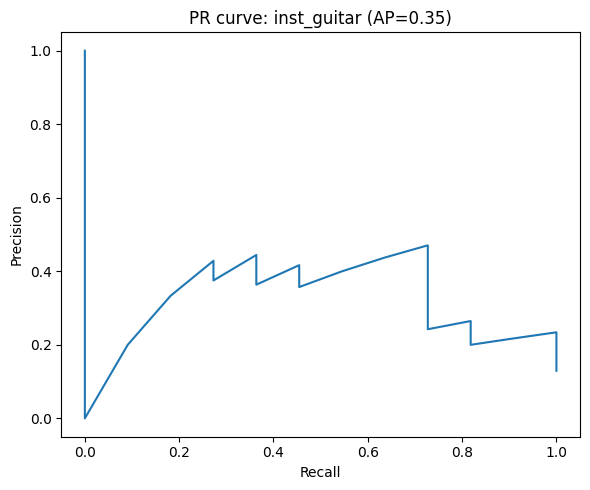

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

target = "inst_guitar"  # যেটা দেখতে চাও
i = classes.index(target) if target in classes else 0
prec, rec, _ = precision_recall_curve(Y[:, i], S[:, i])

plt.figure(figsize=(6,5))
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"PR curve: {classes[i]} (AP={ap[i]:.2f})")
plt.tight_layout(); plt.show()


In [ ]:
import os, numpy as np, librosa, torch

def predict_one(path, model, classes, thr=0.5):
    y,_ = librosa.load(path, sr=16000, mono=True)
    import numpy as np
    DUR=10.0; N_FFT=1024; HOP=320; N_MELS=64
    T = int(16000*DUR); y = y[:T] if len(y)>=T else np.pad(y,(0,T-len(y)))
    # Pass arguments as keyword arguments
    S = librosa.feature.melspectrogram(y=y, sr=16000, n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS)
    S = librosa.power_to_db(S, ref=np.max).astype(np.float32)
    S = (S - S.mean())/(S.std()+1e-8)
    x = torch.from_numpy(S[None,None,...]).to(DEVICE).float()
    with torch.no_grad():
        p = torch.sigmoid(model(x)).cpu().numpy()[0]
    idx = np.where(p>=thr)[0]
    return sorted([(classes[i], float(p[i])) for i in idx], key=lambda z: z[1], reverse=True)

test_file = os.path.join(AUDIO_DIR, test_dl.dataset.df.iloc[0]["filename"])
predict_one(test_file, model, classes, thr=0.5)

[('inst_piano', 0.6554573774337769),
 ('inst_cymbals', 0.5433962345123291),
 ('inst_guitar', 0.5415454506874084),
 ('inst_synthesizer', 0.5269633531570435)]

In [ ]:
from IPython.display import Audio, display
import os

fn = test_dl.dataset.df.iloc[0]["filename"]   # বা labels DataFrame থেকে যে কোনো ফাইল
display(Audio(filename=os.path.join(AUDIO_DIR, fn)))


In [ ]:
import numpy as np, pandas as pd, torch, os, librosa

# পুরো labels.csv নাও
df_all = pd.read_csv(LABEL_CSV)

# সহজ একটা loader (শোনার জন্য path দরকার)
from torch.utils.data import DataLoader, Dataset
class _AllDS(Dataset):
    def __init__(self, df): self.df=df.reset_index(drop=True)
    def __len__(self): return len(self.df)
    def __getitem__(self,i):
        r=self.df.iloc[i]; path=os.path.join(AUDIO_DIR, r.filename)
        # একই mel ফাংশন ব্যবহার করো যেটা ট্রেনিংয়ে ছিল:
        x = load_mel(path)   # shape [1,F,T]
        return torch.from_numpy(x), r.filename

all_dl = DataLoader(_AllDS(df_all), batch_size=8, shuffle=False, num_workers=0)

# সব ফাইলের prob বের করো
model.eval()
probs = []
names = []
with torch.no_grad():
    for x,fn_batch in all_dl:
        x = x.to(DEVICE).float()
        p = torch.sigmoid(model(x)).cpu().numpy()
        probs.append(p); names += list(fn_batch)
probs = np.concatenate(probs, 0)

# কলাম নাম prob_<tag>
prob_cols = [f"prob_{c}" for c in classes]
df_pred = pd.DataFrame(probs, columns=prob_cols)
df_pred.insert(0, "filename", names)
df_join = df_all.merge(df_pred, on="filename", how="left")
df_join.head()


,filename,tags,prob_inst_cymbals,prob_inst_drums,prob_inst_guitar,prob_inst_piano,prob_inst_saxophone,prob_inst_synthesizer,prob_inst_trombone,prob_inst_trumpet,prob_inst_violin,prob_inst_voice
0,000135_483840.ogg,inst_voice,0.532725,0.499231,0.526059,0.545180,0.489357,0.506587,0.456457,0.439701,0.438958,0.494158
1,000178_3840.ogg,inst_voice,0.550214,0.511709,0.523326,0.612174,0.476106,0.541625,0.405656,0.402479,0.395036,0.489687
2,000182_145920.ogg,inst_voice,0.545211,0.518154,0.519175,0.522659,0.501394,0.518337,0.453341,0.437877,0.458897,0.512154
3,000190_126720.ogg,inst_piano,0.490934,0.387481,0.433070,0.345983,0.626894,0.385304,0.665206,0.644001,0.717292,0.428673
4,000208_195840.ogg,inst_piano,0.498454,0.460985,0.510119,0.446675,0.544675,0.441665,0.555555,0.522809,0.547136,0.474088


In [ ]:
from IPython.display import Audio, display

tag = "inst_guitar"           # যেটা শুনতে চাও
k   = 5                       # কয়টা প্লে করবে
col = f"prob_{tag}"
assert col in df_join.columns, f"{tag} not in classes"

pick = df_join.sort_values(col, ascending=False).head(k)
for _,row in pick.iterrows():
    path = os.path.join(AUDIO_DIR, row["filename"])
    print(f"{row['filename']}  ->  {tag}={row[col]:.2f}")
    display(Audio(filename=path))


011324_23040.ogg  ->  inst_guitar=0.55


011352_46080.ogg  ->  inst_guitar=0.55


011375_26880.ogg  ->  inst_guitar=0.55


010027_207360.ogg  ->  inst_guitar=0.55


011335_138240.ogg  ->  inst_guitar=0.55


In [ ]:
from IPython.display import Audio, display

tag = "inst_guitar"           # যেটা শুনতে চাও
k   = 5                       # কয়টা প্লে করবে
col = f"prob_{tag}"
assert col in df_join.columns, f"{tag} not in classes"

pick = df_join.sort_values(col, ascending=False).head(k)
for _,row in pick.iterrows():
    path = os.path.join(AUDIO_DIR, row["filename"])
    print(f"{row['filename']}  ->  {tag}={row[col]:.2f}")
    display(Audio(filename=path))


011324_23040.ogg  ->  inst_guitar=0.55


011352_46080.ogg  ->  inst_guitar=0.55


011375_26880.ogg  ->  inst_guitar=0.55


010027_207360.ogg  ->  inst_guitar=0.55


011335_138240.ogg  ->  inst_guitar=0.55


In [ ]:
from IPython.display import Audio, display
import os, pandas as pd, re

df = pd.read_csv(LABEL_CSV)
mood = "mood_happy"
sub = df[df["tags"].str.contains(rf"\b{re.escape(mood)}\b", case=False, na=False)].head(5)

for _,r in sub.iterrows():
    path=os.path.join(AUDIO_DIR, r["filename"])
    print(r["filename"], "tags:", r["tags"])
    display(Audio(filename=path))


In [ ]:
from IPython.display import Audio, display
import os, pandas as pd, re

# Use the joined DataFrame containing both original tags and predicted probabilities
# We can't filter by predicted mood probabilities as the model was not trained on moods.
# Instead, we filter by the original mood tag in the 'tags' column.

mood = "mood_chill"
k   = 5

# Filter df_join based on the original 'tags' column
sub = df_join[df_join["tags"].str.contains(rf"\b{re.escape(mood)}\b", case=False, na=False)].head(k)

if sub.empty:
    print(f"No files found with the tag '{mood}' in the original labels.")
else:
    for _,r in sub.iterrows():
        path=os.path.join(AUDIO_DIR, r["filename"])
        print(r["filename"], "tags:", r["tags"])
        display(Audio(filename=path))

No files found with the tag 'mood_chill' in the original labels.


In [ ]:
# ==== Mood-wise play from labels.csv (no model required) ====
from IPython.display import Audio, display
import pandas as pd, os, re

# Set your paths
AUDIO_DIR = "/content/audio"
LABEL_CSV = "/content/labels.csv"

# Pick a mood tag that actually exists in your labels.csv
MOOD_TAG = "mood_happy"   # e.g., mood_happy / mood_chill / mood_dark
TOP_K = 5

df = pd.read_csv(LABEL_CSV)
# robust match for comma-separated tags
pattern = rf'(^|,)\s*{re.escape(MOOD_TAG)}\s*(,|$)'
pick = df[df["tags"].str.contains(pattern, case=False, na=False)].head(TOP_K)

print(f"Playing {len(pick)} clips for: {MOOD_TAG}")
for _, r in pick.iterrows():
    path = os.path.join(AUDIO_DIR, r["filename"])
    print(r["filename"], "| tags:", r["tags"])
    display(Audio(filename=path))


Playing 0 clips for: mood_happy


/tmp/ipython-input-1862476849.py:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  pick = df[df["tags"].str.contains(pattern, case=False, na=False)].head(TOP_K)


In [ ]:
# ==== Instrument-wise play from labels.csv (no model required) ====
from IPython.display import Audio, display
import pandas as pd, os, re

AUDIO_DIR = "/content/audio"
LABEL_CSV = "/content/labels.csv"

INST_TAG = "inst_guitar"  # e.g., inst_drums / inst_piano / inst_synth
TOP_K = 5

df = pd.read_csv(LABEL_CSV)
pattern = rf'(^|,)\s*{re.escape(INST_TAG)}\s*(,|$)'
pick = df[df["tags"].str.contains(pattern, case=False, na=False)].head(TOP_K)

print(f"Playing {len(pick)} clips for: {INST_TAG}")
for _, r in pick.iterrows():
    path = os.path.join(AUDIO_DIR, r["filename"])
    print(r["filename"], "| tags:", r["tags"])
    display(Audio(filename=path))


Playing 5 clips for: inst_guitar
000739_0.ogg | tags: inst_guitar


/tmp/ipython-input-649099711.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  pick = df[df["tags"].str.contains(pattern, case=False, na=False)].head(TOP_K)


001335_207360.ogg | tags: inst_guitar


001383_134400.ogg | tags: inst_guitar


001491_99840.ogg | tags: inst_guitar


001492_46080.ogg | tags: inst_guitar


In [ ]:
# ==== Build prediction table (df_join) for all files ====
import numpy as np, pandas as pd, os, torch, librosa
from torch.utils.data import Dataset, DataLoader

# set paths
AUDIO_DIR = "/content/audio"
LABEL_CSV = "/content/labels.csv"

# sanity checks
assert 'model' in globals(), "Train/load your model first (variable `model` must exist)."
assert 'classes' in globals(), "`classes` list must exist."
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model.eval()

# same mel function used in training (edit if your params differ)
SR=16000; N_MELS=64; N_FFT=1024; HOP=320; DUR=10.0
def load_mel(path):
    y,_ = librosa.load(path, sr=SR, mono=True)
    T = int(SR*DUR)
    y = y[:T] if len(y)>=T else np.pad(y,(0,T-len(y)))
    # Pass arguments as keyword arguments
    S = librosa.feature.melspectrogram(y=y, sr=SR, n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS)
    S = librosa.power_to_db(S, ref=np.max).astype(np.float32)
    S = (S - S.mean())/(S.std()+1e-8)
    return S[None, ...]  # [1,F,T]

class AllFilesDS(Dataset):
    def __init__(self, df): self.df = df.reset_index(drop=True)
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        x = load_mel(os.path.join(AUDIO_DIR, r["filename"]))
        return torch.from_numpy(x), r["filename"]

df_all = pd.read_csv(LABEL_CSV)
dl = DataLoader(AllFilesDS(df_all), batch_size=8, shuffle=False, num_workers=0)

# run inference for all files
names, probs = [], []
with torch.no_grad():
    for x, fns in dl:
        x = x.to(DEVICE).float()
        p = torch.sigmoid(model(x)).cpu().numpy()
        probs.append(p); names += list(fns)
probs = np.concatenate(probs, axis=0)

# merge into df_join (has prob_<tag> columns)
prob_cols = [f"prob_{c}" for c in classes]
df_pred = pd.DataFrame(probs, columns=prob_cols)
df_pred.insert(0, "filename", names)
df_join = df_all.merge(df_pred, on="filename", how="left")
print("df_join columns:", df_join.columns.tolist()[:10], "... total:", len(df_join.columns))
df_join.head()

df_join columns: ['filename', 'tags', 'prob_inst_cymbals', 'prob_inst_drums', 'prob_inst_guitar', 'prob_inst_piano', 'prob_inst_saxophone', 'prob_inst_synthesizer', 'prob_inst_trombone', 'prob_inst_trumpet'] ... total: 12


,filename,tags,prob_inst_cymbals,prob_inst_drums,prob_inst_guitar,prob_inst_piano,prob_inst_saxophone,prob_inst_synthesizer,prob_inst_trombone,prob_inst_trumpet,prob_inst_violin,prob_inst_voice
0,000135_483840.ogg,inst_voice,0.532725,0.499231,0.526059,0.545180,0.489357,0.506587,0.456457,0.439701,0.438958,0.494158
1,000178_3840.ogg,inst_voice,0.550214,0.511709,0.523326,0.612174,0.476106,0.541625,0.405656,0.402479,0.395036,0.489687
2,000182_145920.ogg,inst_voice,0.545211,0.518154,0.519175,0.522659,0.501394,0.518337,0.453341,0.437877,0.458897,0.512154
3,000190_126720.ogg,inst_piano,0.490934,0.387481,0.433070,0.345983,0.626894,0.385304,0.665206,0.644001,0.717292,0.428673
4,000208_195840.ogg,inst_piano,0.498454,0.460985,0.510119,0.446675,0.544675,0.441665,0.555555,0.522809,0.547136,0.474088


In [ ]:
from IPython.display import Audio, display
import os

TAG = "inst_guitar"      # any tag from `classes` (inst_* or mood_* if present)
TOP_K = 5
col = f"prob_{TAG}"
assert col in df_join.columns, f"{TAG} not found in predictions."

topk = df_join.sort_values(col, ascending=False).head(TOP_K)
print(f"Top {TOP_K} for {TAG}")
for _, r in topk.iterrows():
    path = os.path.join(AUDIO_DIR, r["filename"])
    print(f"{r['filename']}  ->  {TAG}={r[col]:.2f}")
    display(Audio(filename=path))


Top 5 for inst_guitar
011324_23040.ogg  ->  inst_guitar=0.55


011352_46080.ogg  ->  inst_guitar=0.55


011375_26880.ogg  ->  inst_guitar=0.55


010027_207360.ogg  ->  inst_guitar=0.55


011335_138240.ogg  ->  inst_guitar=0.55


In [ ]:
# predicted probability columns (what the model actually learned)
pred_cols = sorted([c[5:] for c in df_join.columns if c.startswith("prob_")])
print("Predicted tags:", pred_cols)


Predicted tags: ['inst_cymbals', 'inst_drums', 'inst_guitar', 'inst_piano', 'inst_saxophone', 'inst_synthesizer', 'inst_trombone', 'inst_trumpet', 'inst_violin', 'inst_voice']
